<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Nalinda/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ✅ Step 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Bidirectional, BatchNormalization

# reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [15]:
# ✅ Step 3: Advanced Train/Test Data Loading from Google Drive
import pandas as pd
import os

# Paths to your files
train_path = "/content/drive/MyDrive/DiabetesPrediction/outputs/train.csv"
test_path  = "/content/drive/MyDrive/DiabetesPrediction/outputs/test.csv"

# Check file existence before loading
for path in [train_path, test_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ File not found: {path}\nPlease verify the path in Google Drive.")

# Load CSV files
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# ✅ Display dataset info
print("✅ Train shape:", train_df.shape)
print("✅ Test shape:",  test_df.shape)
print("\n🧩 Columns in dataset:\n", list(train_df.columns))
print("\n📋 Data types:\n", train_df.dtypes)
print("\n🔍 Missing values per column:\n", train_df.isnull().sum())

# Quick look at class distribution (assuming 'diabetes' is your target)
target_col = 'diabetes'
if target_col in train_df.columns:
    print("\n⚖️ Class distribution in train set:")
    print(train_df[target_col].value_counts(normalize=True).rename({0: "Non-Diabetic", 1: "Diabetic"}))

# Show first few records
print("\n📘 Sample records:")
display(train_df.head())

print("\n✅ Train and Test datasets successfully loaded from Google Drive!")


✅ Train shape: (140262, 9)
✅ Test shape: (35066, 9)

🧩 Columns in dataset:
 ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

📋 Data types:
 gender                 float64
age                    float64
hypertension           float64
heart_disease          float64
smoking_history        float64
bmi                    float64
HbA1c_level            float64
blood_glucose_level    float64
diabetes                 int64
dtype: object

🔍 Missing values per column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

⚖️ Class distribution in train set:
diabetes
Diabetic        0.5
Non-Diabetic    0.5
Name: proportion, dtype: float64

📘 Sample records:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1.183769,1.693635,3.447677,4.848534,0.408968,0.761924,2.496579,0.054263,1
1,1.183769,0.308435,-0.290050,-0.206248,-1.186816,0.055526,1.373995,0.047584,1
2,-0.843459,-1.014757,-0.290050,-0.206248,-1.186816,0.006561,-0.684077,0.518038,0
3,-0.843459,0.945914,-0.290050,-0.206248,0.940896,0.094711,3.057872,3.514083,1
4,-0.843459,0.358859,-0.290050,-0.206248,0.940896,2.832448,0.438507,-0.129164,1



✅ Train and Test datasets successfully loaded from Google Drive!


In [4]:
# ✅ Step 4: Split features and target
target_col = 'diabetes'  # change if your column name is different

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values
X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col].values

print("Features:", X_train.shape[1], " Target distribution:", np.bincount(y_train))


Features: 8  Target distribution: [70131 70131]


In [5]:
# ✅ Step 5: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [6]:
# ✅ Step 6: Reshape for LSTM (each feature = timestep)
X_train_seq = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_seq  = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("Train seq shape:", X_train_seq.shape)


Train seq shape: (140262, 8, 1)


In [7]:
# ✅ Step 7: Define advanced LSTM model
def build_lstm(input_shape):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4)))(inp)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(32))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

model = build_lstm((X_train_seq.shape[1], 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 128)         │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 8, 128)         │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,633 (303.25 KB)

 Trainable params: 77,505 (302.75 KB)

 Non-trainable params: 128 (512.00 B)

In [8]:
# ✅ Step 8: Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, mode='max')
checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/DiabetesPrediction/best_lstm.h5', save_best_only=True, monitor='val_auc', mode='max')


In [9]:
# ✅ Step 9: Train model
history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)
+

Epoch 1/100


3507/3507 - 84s - 24ms/step - accuracy: 0.8906 - auc: 0.9652 - loss: 0.2393 - val_accuracy: 0.9040 - val_auc: 0.9754 - val_loss: 0.1973 - learning_rate: 1.0000e-03
Epoch 2/100


3507/3507 - 80s - 23ms/step - accuracy: 0.9038 - auc: 0.9737 - loss: 0.2046 - val_accuracy: 0.9100 - val_auc: 0.9777 - val_loss: 0.1888 - learning_rate: 1.0000e-03
Epoch 3/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9059 - auc: 0.9753 - loss: 0.1977 - val_accuracy: 0.9084 - val_auc: 0.9769 - val_loss: 0.1914 - learning_rate: 1.0000e-03
Epoch 4/100


3507/3507 - 82s - 23ms/step - accuracy: 0.9079 - auc: 0.9759 - loss: 0.1948 - val_accuracy: 0.9100 - val_auc: 0.9779 - val_loss: 0.1863 - learning_rate: 1.0000e-03
Epoch 5/100


3507/3507 - 75s - 21ms/step - accuracy: 0.9085 - auc: 0.9764 - loss: 0.1922 - val_accuracy: 0.9099 - val_auc: 0.9785 - val_loss: 0.1836 - learning_rate: 1.0000e-03
Epoch 6/100


3507/3507 - 76s - 22ms/step - accuracy: 0.9089 - auc: 0.9769 - loss: 0.1899 - val_accuracy: 0.9121 - val_auc: 0.9787 - val_loss: 0.1821 - learning_rate: 1.0000e-03
Epoch 7/100


3507/3507 - 74s - 21ms/step - accuracy: 0.9096 - auc: 0.9770 - loss: 0.1895 - val_accuracy: 0.9122 - val_auc: 0.9790 - val_loss: 0.1806 - learning_rate: 1.0000e-03
Epoch 8/100
3507/3507 - 82s - 23ms/step - accuracy: 0.9097 - auc: 0.9772 - loss: 0.1880 - val_accuracy: 0.9119 - val_auc: 0.9789 - val_loss: 0.1817 - learning_rate: 1.0000e-03
Epoch 9/100


3507/3507 - 82s - 23ms/step - accuracy: 0.9095 - auc: 0.9773 - loss: 0.1877 - val_accuracy: 0.9132 - val_auc: 0.9791 - val_loss: 0.1826 - learning_rate: 1.0000e-03
Epoch 10/100


3507/3507 - 75s - 21ms/step - accuracy: 0.9106 - auc: 0.9775 - loss: 0.1871 - val_accuracy: 0.9132 - val_auc: 0.9794 - val_loss: 0.1786 - learning_rate: 1.0000e-03
Epoch 11/100


3507/3507 - 74s - 21ms/step - accuracy: 0.9108 - auc: 0.9777 - loss: 0.1858 - val_accuracy: 0.9137 - val_auc: 0.9796 - val_loss: 0.1778 - learning_rate: 1.0000e-03
Epoch 12/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9109 - auc: 0.9780 - loss: 0.1848 - val_accuracy: 0.9127 - val_auc: 0.9794 - val_loss: 0.1788 - learning_rate: 1.0000e-03
Epoch 13/100


3507/3507 - 83s - 24ms/step - accuracy: 0.9114 - auc: 0.9782 - loss: 0.1839 - val_accuracy: 0.9157 - val_auc: 0.9799 - val_loss: 0.1771 - learning_rate: 1.0000e-03
Epoch 14/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9105 - auc: 0.9779 - loss: 0.1848 - val_accuracy: 0.9128 - val_auc: 0.9796 - val_loss: 0.1787 - learning_rate: 1.0000e-03
Epoch 15/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9117 - auc: 0.9785 - loss: 0.1828 - val_accuracy: 0.9153 - val_auc: 0.9803 - val_loss: 0.1755 - learning_rate: 1.0000e-03
Epoch 16/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9131 - auc: 0.9788 - loss: 0.1819 - val_accuracy: 0.9160 - val_auc: 0.9802 - val_loss: 0.1754 - learning_rate: 1.0000e-03
Epoch 17/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9129 - auc: 0.9789 - loss: 0.1808 - val_accuracy: 0.9125 - val_auc: 0.9788 - val_loss: 0.1808 - learning_rate: 1.0000e-03
Epoch 18/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9129 - auc: 0.9788 - loss: 0.1817 - val_accuracy: 0.9160 - val_auc: 0.9805 - val_loss: 0.1743 - learning_rate: 1.0000e-03
Epoch 19/100
3507/3507 - 74s - 21ms/step - accuracy: 0.9133 - auc: 0.9792 - loss: 0.1797 - val_accuracy: 0.9148 - val_auc: 0.9803 - val_loss: 0.1747 - learning_rate: 1.0000e-03
Epoch 20/100


3507/3507 - 80s - 23ms/step - accuracy: 0.9129 - auc: 0.9792 - loss: 0.1796 - val_accuracy: 0.9153 - val_auc: 0.9805 - val_loss: 0.1743 - learning_rate: 1.0000e-03
Epoch 21/100
3507/3507 - 78s - 22ms/step - accuracy: 0.9133 - auc: 0.9793 - loss: 0.1790 - val_accuracy: 0.9147 - val_auc: 0.9801 - val_loss: 0.1762 - learning_rate: 1.0000e-03
Epoch 22/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9147 - auc: 0.9796 - loss: 0.1779 - val_accuracy: 0.9154 - val_auc: 0.9807 - val_loss: 0.1734 - learning_rate: 1.0000e-03
Epoch 23/100
3507/3507 - 81s - 23ms/step - accuracy: 0.9144 - auc: 0.9796 - loss: 0.1780 - val_accuracy: 0.9158 - val_auc: 0.9806 - val_loss: 0.1741 - learning_rate: 1.0000e-03
Epoch 24/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9151 - auc: 0.9800 - loss: 0.1768 - val_accuracy: 0.9147 - val_auc: 0.9801 - val_loss: 0.1755 - learning_rate: 1.0000e-03
Epoch 25/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9151 - auc: 0.9800 - loss: 0.1764 - val_accuracy: 0.9179 - val_auc: 0.9812 - val_loss: 0.1714 - learning_rate: 1.0000e-03
Epoch 26/100


3507/3507 - 75s - 21ms/step - accuracy: 0.9149 - auc: 0.9801 - loss: 0.1763 - val_accuracy: 0.9179 - val_auc: 0.9813 - val_loss: 0.1709 - learning_rate: 1.0000e-03
Epoch 27/100


3507/3507 - 74s - 21ms/step - accuracy: 0.9151 - auc: 0.9803 - loss: 0.1750 - val_accuracy: 0.9178 - val_auc: 0.9814 - val_loss: 0.1711 - learning_rate: 1.0000e-03
Epoch 28/100


3507/3507 - 81s - 23ms/step - accuracy: 0.9162 - auc: 0.9805 - loss: 0.1740 - val_accuracy: 0.9172 - val_auc: 0.9814 - val_loss: 0.1702 - learning_rate: 1.0000e-03
Epoch 29/100
3507/3507 - 74s - 21ms/step - accuracy: 0.9168 - auc: 0.9807 - loss: 0.1734 - val_accuracy: 0.9160 - val_auc: 0.9809 - val_loss: 0.1734 - learning_rate: 1.0000e-03
Epoch 30/100


3507/3507 - 75s - 21ms/step - accuracy: 0.9161 - auc: 0.9807 - loss: 0.1732 - val_accuracy: 0.9193 - val_auc: 0.9818 - val_loss: 0.1700 - learning_rate: 1.0000e-03
Epoch 31/100


3507/3507 - 80s - 23ms/step - accuracy: 0.9181 - auc: 0.9810 - loss: 0.1722 - val_accuracy: 0.9184 - val_auc: 0.9820 - val_loss: 0.1675 - learning_rate: 1.0000e-03
Epoch 32/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9172 - auc: 0.9809 - loss: 0.1726 - val_accuracy: 0.9168 - val_auc: 0.9815 - val_loss: 0.1712 - learning_rate: 1.0000e-03
Epoch 33/100


3507/3507 - 82s - 23ms/step - accuracy: 0.9176 - auc: 0.9812 - loss: 0.1713 - val_accuracy: 0.9185 - val_auc: 0.9821 - val_loss: 0.1671 - learning_rate: 1.0000e-03
Epoch 34/100


3507/3507 - 78s - 22ms/step - accuracy: 0.9173 - auc: 0.9810 - loss: 0.1724 - val_accuracy: 0.9196 - val_auc: 0.9823 - val_loss: 0.1662 - learning_rate: 1.0000e-03
Epoch 35/100


3507/3507 - 74s - 21ms/step - accuracy: 0.9182 - auc: 0.9815 - loss: 0.1701 - val_accuracy: 0.9207 - val_auc: 0.9824 - val_loss: 0.1662 - learning_rate: 1.0000e-03
Epoch 36/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9185 - auc: 0.9816 - loss: 0.1694 - val_accuracy: 0.9193 - val_auc: 0.9824 - val_loss: 0.1652 - learning_rate: 1.0000e-03
Epoch 37/100


3507/3507 - 82s - 23ms/step - accuracy: 0.9186 - auc: 0.9817 - loss: 0.1690 - val_accuracy: 0.9193 - val_auc: 0.9825 - val_loss: 0.1651 - learning_rate: 1.0000e-03
Epoch 38/100
3507/3507 - 81s - 23ms/step - accuracy: 0.9200 - auc: 0.9820 - loss: 0.1679 - val_accuracy: 0.9213 - val_auc: 0.9823 - val_loss: 0.1660 - learning_rate: 1.0000e-03
Epoch 39/100
3507/3507 - 82s - 23ms/step - accuracy: 0.9200 - auc: 0.9821 - loss: 0.1673 - val_accuracy: 0.9169 - val_auc: 0.9804 - val_loss: 0.1747 - learning_rate: 1.0000e-03
Epoch 40/100


3507/3507 - 72s - 21ms/step - accuracy: 0.9202 - auc: 0.9822 - loss: 0.1668 - val_accuracy: 0.9214 - val_auc: 0.9827 - val_loss: 0.1638 - learning_rate: 1.0000e-03
Epoch 41/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9195 - auc: 0.9822 - loss: 0.1670 - val_accuracy: 0.9188 - val_auc: 0.9821 - val_loss: 0.1675 - learning_rate: 1.0000e-03
Epoch 42/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9214 - auc: 0.9826 - loss: 0.1655 - val_accuracy: 0.9228 - val_auc: 0.9832 - val_loss: 0.1620 - learning_rate: 1.0000e-03
Epoch 43/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9210 - auc: 0.9826 - loss: 0.1649 - val_accuracy: 0.9221 - val_auc: 0.9834 - val_loss: 0.1608 - learning_rate: 1.0000e-03
Epoch 44/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9209 - auc: 0.9826 - loss: 0.1655 - val_accuracy: 0.9216 - val_auc: 0.9833 - val_loss: 0.1618 - learning_rate: 1.0000e-03
Epoch 45/100
3507/3507 - 78s - 22ms/step - accuracy: 0.9215 - auc: 0.9827 - loss: 0.1644 - val_accuracy: 0.9231 - val_auc: 0.9833 - val_loss: 0.1612 - learning_rate: 1.0000e-03
Epoch 46/100


3507/3507 - 80s - 23ms/step - accuracy: 0.9217 - auc: 0.9829 - loss: 0.1641 - val_accuracy: 0.9241 - val_auc: 0.9839 - val_loss: 0.1586 - learning_rate: 1.0000e-03
Epoch 47/100
3507/3507 - 75s - 21ms/step - accuracy: 0.9223 - auc: 0.9831 - loss: 0.1626 - val_accuracy: 0.9214 - val_auc: 0.9829 - val_loss: 0.1641 - learning_rate: 1.0000e-03
Epoch 48/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9225 - auc: 0.9834 - loss: 0.1613 - val_accuracy: 0.9238 - val_auc: 0.9837 - val_loss: 0.1595 - learning_rate: 1.0000e-03
Epoch 49/100


3507/3507 - 72s - 21ms/step - accuracy: 0.9225 - auc: 0.9832 - loss: 0.1624 - val_accuracy: 0.9252 - val_auc: 0.9841 - val_loss: 0.1585 - learning_rate: 1.0000e-03
Epoch 50/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9232 - auc: 0.9835 - loss: 0.1608 - val_accuracy: 0.9226 - val_auc: 0.9835 - val_loss: 0.1611 - learning_rate: 1.0000e-03
Epoch 51/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9242 - auc: 0.9836 - loss: 0.1607 - val_accuracy: 0.9247 - val_auc: 0.9839 - val_loss: 0.1602 - learning_rate: 1.0000e-03
Epoch 52/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9237 - auc: 0.9836 - loss: 0.1607 - val_accuracy: 0.9247 - val_auc: 0.9838 - val_loss: 0.1592 - learning_rate: 1.0000e-03
Epoch 53/100


3507/3507 - 74s - 21ms/step - accuracy: 0.9240 - auc: 0.9838 - loss: 0.1598 - val_accuracy: 0.9249 - val_auc: 0.9842 - val_loss: 0.1568 - learning_rate: 1.0000e-03
Epoch 54/100


3507/3507 - 74s - 21ms/step - accuracy: 0.9244 - auc: 0.9839 - loss: 0.1590 - val_accuracy: 0.9269 - val_auc: 0.9845 - val_loss: 0.1564 - learning_rate: 1.0000e-03
Epoch 55/100
3507/3507 - 82s - 23ms/step - accuracy: 0.9250 - auc: 0.9842 - loss: 0.1581 - val_accuracy: 0.9256 - val_auc: 0.9843 - val_loss: 0.1565 - learning_rate: 1.0000e-03
Epoch 56/100
3507/3507 - 81s - 23ms/step - accuracy: 0.9250 - auc: 0.9842 - loss: 0.1580 - val_accuracy: 0.9267 - val_auc: 0.9844 - val_loss: 0.1567 - learning_rate: 1.0000e-03
Epoch 57/100
3507/3507 - 73s - 21ms/step - accuracy: 0.9255 - auc: 0.9842 - loss: 0.1585 - val_accuracy: 0.9259 - val_auc: 0.9838 - val_loss: 0.1590 - learning_rate: 1.0000e-03
Epoch 58/100


3507/3507 - 78s - 22ms/step - accuracy: 0.9253 - auc: 0.9842 - loss: 0.1575 - val_accuracy: 0.9279 - val_auc: 0.9846 - val_loss: 0.1550 - learning_rate: 1.0000e-03
Epoch 59/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9258 - auc: 0.9843 - loss: 0.1575 - val_accuracy: 0.9262 - val_auc: 0.9846 - val_loss: 0.1553 - learning_rate: 1.0000e-03
Epoch 60/100


3507/3507 - 72s - 21ms/step - accuracy: 0.9272 - auc: 0.9848 - loss: 0.1550 - val_accuracy: 0.9275 - val_auc: 0.9847 - val_loss: 0.1555 - learning_rate: 1.0000e-03
Epoch 61/100
3507/3507 - 78s - 22ms/step - accuracy: 0.9262 - auc: 0.9846 - loss: 0.1553 - val_accuracy: 0.9269 - val_auc: 0.9847 - val_loss: 0.1552 - learning_rate: 1.0000e-03
Epoch 62/100


3507/3507 - 77s - 22ms/step - accuracy: 0.9266 - auc: 0.9847 - loss: 0.1557 - val_accuracy: 0.9273 - val_auc: 0.9852 - val_loss: 0.1525 - learning_rate: 1.0000e-03
Epoch 63/100
3507/3507 - 80s - 23ms/step - accuracy: 0.9274 - auc: 0.9849 - loss: 0.1545 - val_accuracy: 0.9282 - val_auc: 0.9851 - val_loss: 0.1528 - learning_rate: 1.0000e-03
Epoch 64/100
3507/3507 - 77s - 22ms/step - accuracy: 0.9274 - auc: 0.9849 - loss: 0.1546 - val_accuracy: 0.9260 - val_auc: 0.9849 - val_loss: 0.1535 - learning_rate: 1.0000e-03
Epoch 65/100
3507/3507 - 71s - 20ms/step - accuracy: 0.9277 - auc: 0.9850 - loss: 0.1547 - val_accuracy: 0.9269 - val_auc: 0.9848 - val_loss: 0.1534 - learning_rate: 1.0000e-03
Epoch 66/100
3507/3507 - 71s - 20ms/step - accuracy: 0.9278 - auc: 0.9851 - loss: 0.1540 - val_accuracy: 0.9255 - val_auc: 0.9846 - val_loss: 0.1549 - learning_rate: 1.0000e-03
Epoch 67/100
3507/3507 - 72s - 20ms/step - accuracy: 0.9278 - auc: 0.9851 - loss: 0.1535 - val_accuracy: 0.9265 - val_auc: 0.984

3507/3507 - 83s - 24ms/step - accuracy: 0.9307 - auc: 0.9861 - loss: 0.1483 - val_accuracy: 0.9291 - val_auc: 0.9858 - val_loss: 0.1495 - learning_rate: 5.0000e-04
Epoch 69/100


3507/3507 - 75s - 21ms/step - accuracy: 0.9323 - auc: 0.9866 - loss: 0.1457 - val_accuracy: 0.9292 - val_auc: 0.9862 - val_loss: 0.1472 - learning_rate: 5.0000e-04
Epoch 70/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9322 - auc: 0.9867 - loss: 0.1448 - val_accuracy: 0.9305 - val_auc: 0.9863 - val_loss: 0.1467 - learning_rate: 5.0000e-04
Epoch 71/100


3507/3507 - 81s - 23ms/step - accuracy: 0.9327 - auc: 0.9868 - loss: 0.1443 - val_accuracy: 0.9318 - val_auc: 0.9864 - val_loss: 0.1459 - learning_rate: 5.0000e-04
Epoch 72/100
3507/3507 - 71s - 20ms/step - accuracy: 0.9329 - auc: 0.9867 - loss: 0.1448 - val_accuracy: 0.9307 - val_auc: 0.9863 - val_loss: 0.1463 - learning_rate: 5.0000e-04
Epoch 73/100


3507/3507 - 83s - 24ms/step - accuracy: 0.9337 - auc: 0.9869 - loss: 0.1441 - val_accuracy: 0.9318 - val_auc: 0.9867 - val_loss: 0.1444 - learning_rate: 5.0000e-04
Epoch 74/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9336 - auc: 0.9870 - loss: 0.1433 - val_accuracy: 0.9318 - val_auc: 0.9865 - val_loss: 0.1450 - learning_rate: 5.0000e-04
Epoch 75/100


3507/3507 - 82s - 23ms/step - accuracy: 0.9333 - auc: 0.9869 - loss: 0.1431 - val_accuracy: 0.9322 - val_auc: 0.9867 - val_loss: 0.1439 - learning_rate: 5.0000e-04
Epoch 76/100
3507/3507 - 82s - 23ms/step - accuracy: 0.9337 - auc: 0.9870 - loss: 0.1429 - val_accuracy: 0.9318 - val_auc: 0.9865 - val_loss: 0.1449 - learning_rate: 5.0000e-04
Epoch 77/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9344 - auc: 0.9873 - loss: 0.1417 - val_accuracy: 0.9322 - val_auc: 0.9867 - val_loss: 0.1439 - learning_rate: 5.0000e-04
Epoch 78/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9344 - auc: 0.9873 - loss: 0.1419 - val_accuracy: 0.9329 - val_auc: 0.9869 - val_loss: 0.1432 - learning_rate: 5.0000e-04
Epoch 79/100


3507/3507 - 85s - 24ms/step - accuracy: 0.9349 - auc: 0.9875 - loss: 0.1406 - val_accuracy: 0.9339 - val_auc: 0.9871 - val_loss: 0.1419 - learning_rate: 5.0000e-04
Epoch 80/100
3507/3507 - 72s - 20ms/step - accuracy: 0.9351 - auc: 0.9874 - loss: 0.1415 - val_accuracy: 0.9330 - val_auc: 0.9869 - val_loss: 0.1432 - learning_rate: 5.0000e-04
Epoch 81/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9344 - auc: 0.9875 - loss: 0.1405 - val_accuracy: 0.9343 - val_auc: 0.9870 - val_loss: 0.1426 - learning_rate: 5.0000e-04
Epoch 82/100
3507/3507 - 71s - 20ms/step - accuracy: 0.9355 - auc: 0.9876 - loss: 0.1397 - val_accuracy: 0.9329 - val_auc: 0.9868 - val_loss: 0.1437 - learning_rate: 5.0000e-04
Epoch 83/100


3507/3507 - 72s - 21ms/step - accuracy: 0.9353 - auc: 0.9875 - loss: 0.1407 - val_accuracy: 0.9351 - val_auc: 0.9871 - val_loss: 0.1423 - learning_rate: 5.0000e-04
Epoch 84/100
3507/3507 - 72s - 20ms/step - accuracy: 0.9352 - auc: 0.9877 - loss: 0.1399 - val_accuracy: 0.9344 - val_auc: 0.9870 - val_loss: 0.1429 - learning_rate: 5.0000e-04
Epoch 85/100


3507/3507 - 83s - 24ms/step - accuracy: 0.9376 - auc: 0.9883 - loss: 0.1361 - val_accuracy: 0.9356 - val_auc: 0.9874 - val_loss: 0.1406 - learning_rate: 2.5000e-04
Epoch 86/100
3507/3507 - 81s - 23ms/step - accuracy: 0.9377 - auc: 0.9884 - loss: 0.1353 - val_accuracy: 0.9356 - val_auc: 0.9874 - val_loss: 0.1404 - learning_rate: 2.5000e-04
Epoch 87/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9385 - auc: 0.9884 - loss: 0.1350 - val_accuracy: 0.9352 - val_auc: 0.9875 - val_loss: 0.1401 - learning_rate: 2.5000e-04
Epoch 88/100
3507/3507 - 72s - 20ms/step - accuracy: 0.9379 - auc: 0.9883 - loss: 0.1350 - val_accuracy: 0.9350 - val_auc: 0.9875 - val_loss: 0.1400 - learning_rate: 2.5000e-04
Epoch 89/100
3507/3507 - 71s - 20ms/step - accuracy: 0.9385 - auc: 0.9884 - loss: 0.1347 - val_accuracy: 0.9349 - val_auc: 0.9874 - val_loss: 0.1401 - learning_rate: 2.5000e-04
Epoch 90/100


3507/3507 - 82s - 23ms/step - accuracy: 0.9391 - auc: 0.9887 - loss: 0.1337 - val_accuracy: 0.9365 - val_auc: 0.9876 - val_loss: 0.1396 - learning_rate: 2.5000e-04
Epoch 91/100
3507/3507 - 83s - 24ms/step - accuracy: 0.9382 - auc: 0.9885 - loss: 0.1347 - val_accuracy: 0.9361 - val_auc: 0.9875 - val_loss: 0.1395 - learning_rate: 2.5000e-04
Epoch 92/100
3507/3507 - 82s - 23ms/step - accuracy: 0.9383 - auc: 0.9886 - loss: 0.1338 - val_accuracy: 0.9356 - val_auc: 0.9876 - val_loss: 0.1390 - learning_rate: 2.5000e-04
Epoch 93/100
3507/3507 - 83s - 24ms/step - accuracy: 0.9391 - auc: 0.9886 - loss: 0.1341 - val_accuracy: 0.9357 - val_auc: 0.9874 - val_loss: 0.1405 - learning_rate: 2.5000e-04
Epoch 94/100
3507/3507 - 72s - 20ms/step - accuracy: 0.9395 - auc: 0.9887 - loss: 0.1335 - val_accuracy: 0.9366 - val_auc: 0.9876 - val_loss: 0.1394 - learning_rate: 2.5000e-04
Epoch 95/100


3507/3507 - 73s - 21ms/step - accuracy: 0.9397 - auc: 0.9889 - loss: 0.1321 - val_accuracy: 0.9365 - val_auc: 0.9879 - val_loss: 0.1372 - learning_rate: 2.5000e-04
Epoch 96/100


3507/3507 - 81s - 23ms/step - accuracy: 0.9395 - auc: 0.9890 - loss: 0.1318 - val_accuracy: 0.9365 - val_auc: 0.9880 - val_loss: 0.1377 - learning_rate: 2.5000e-04
Epoch 97/100
3507/3507 - 81s - 23ms/step - accuracy: 0.9394 - auc: 0.9888 - loss: 0.1332 - val_accuracy: 0.9364 - val_auc: 0.9877 - val_loss: 0.1387 - learning_rate: 2.5000e-04
Epoch 98/100
3507/3507 - 71s - 20ms/step - accuracy: 0.9388 - auc: 0.9889 - loss: 0.1325 - val_accuracy: 0.9360 - val_auc: 0.9879 - val_loss: 0.1384 - learning_rate: 2.5000e-04
Epoch 99/100
3507/3507 - 72s - 21ms/step - accuracy: 0.9397 - auc: 0.9890 - loss: 0.1318 - val_accuracy: 0.9359 - val_auc: 0.9878 - val_loss: 0.1386 - learning_rate: 2.5000e-04
Epoch 100/100


3507/3507 - 72s - 20ms/step - accuracy: 0.9402 - auc: 0.9889 - loss: 0.1319 - val_accuracy: 0.9381 - val_auc: 0.9880 - val_loss: 0.1365 - learning_rate: 2.5000e-04


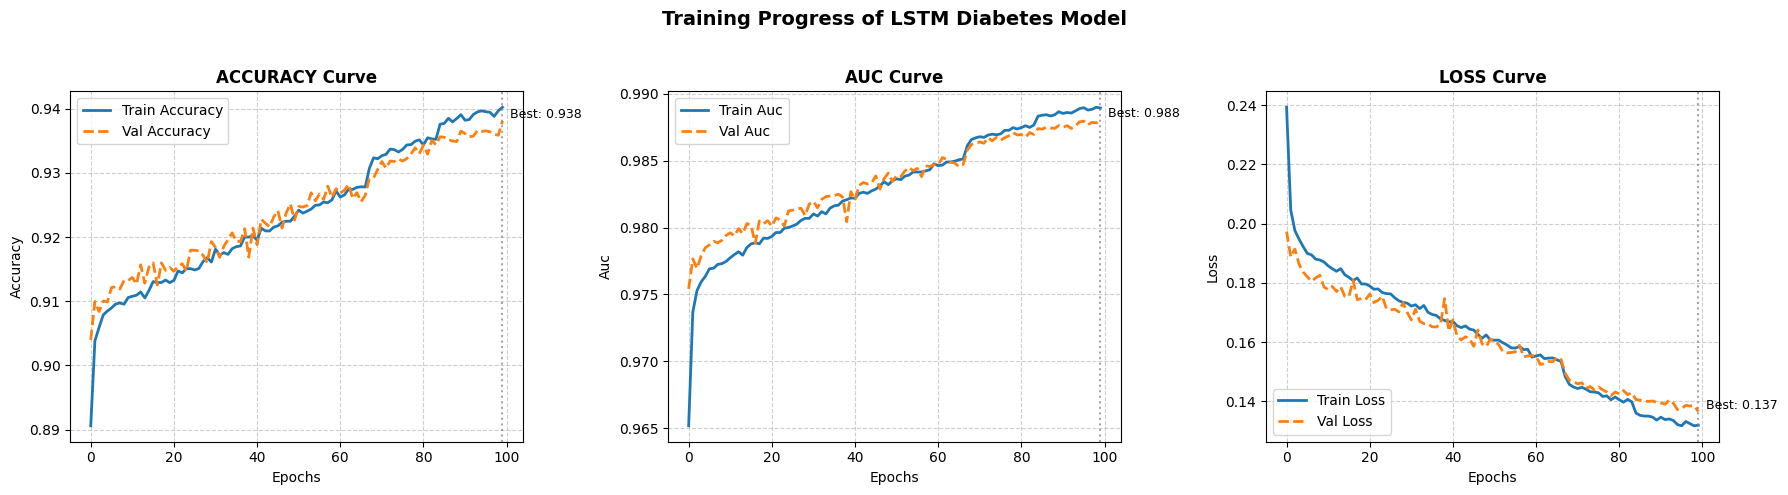

✅ Training plots saved at: /content/drive/MyDrive/DL_Project/plots/training_curves.png


In [13]:
# ✅ Step 10: Advanced Training Visualization

import matplotlib.pyplot as plt
import numpy as np
import os

# Create a save path (optional)
save_dir = "/content/drive/MyDrive/DL_Project/plots"
os.makedirs(save_dir, exist_ok=True)

# Helper function to plot any metric
def plot_metric(metric_name, history, ax):
    train_metric = history.history.get(metric_name)
    val_metric = history.history.get(f'val_{metric_name}')

    if train_metric and val_metric:
        ax.plot(train_metric, label=f'Train {metric_name.capitalize()}', linewidth=2)
        ax.plot(val_metric, label=f'Val {metric_name.capitalize()}', linewidth=2, linestyle='--')
        ax.set_title(f'{metric_name.upper()} Curve', fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_name.capitalize())
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        # Annotate best validation metric
        best_epoch = np.argmax(val_metric) if metric_name != 'loss' else np.argmin(val_metric)
        ax.axvline(best_epoch, color='gray', linestyle=':', alpha=0.7)
        ax.text(best_epoch, val_metric[best_epoch], f'  Best: {val_metric[best_epoch]:.3f}',
                color='black', fontsize=9, verticalalignment='bottom')
    else:
        ax.text(0.5, 0.5, f"{metric_name} not found in history",
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Accuracy, AUC, and Loss
plot_metric('accuracy', history, axs[0])
plot_metric('auc', history, axs[1])
plot_metric('loss', history, axs[2])

plt.suptitle('Training Progress of LSTM Diabetes Model', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Optionally save the figure
fig.savefig(os.path.join(save_dir, "training_curves.png"), dpi=300)
print(f"✅ Training plots saved at: {os.path.join(save_dir, 'training_curves.png')}")


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
===== Classification Report =====
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     17533
           1       0.91      0.97      0.94     17533

    accuracy                           0.94     35066
   macro avg       0.94      0.94      0.94     35066
weighted avg       0.94      0.94      0.94     35066

✅ Accuracy:  0.9363
✅ Precision: 0.9067
✅ Recall:    0.9727
✅ F1-Score:  0.9385
✅ AUC:       0.9878


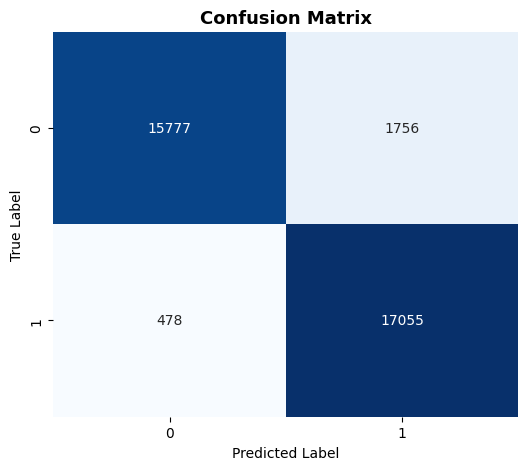

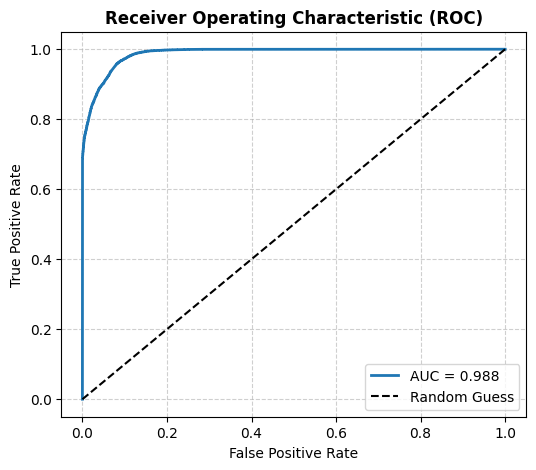

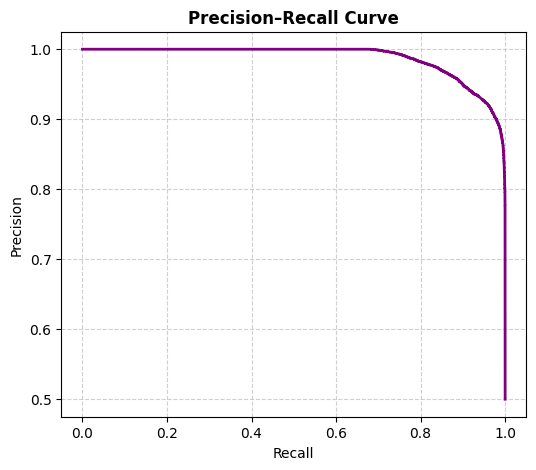

✅ Evaluation plots saved in: /content/drive/MyDrive/DL_Project/plots


In [17]:
# ✅ Step 11: Advanced Model Evaluation and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
import numpy as np
import os

# Make predictions
y_prob = model.predict(X_test_seq).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# 📊 Compute Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("===== Classification Report =====")
print(classification_report(y_test, y_pred))
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1-Score:  {f1:.4f}")
print(f"✅ AUC:       {auc:.4f}")

# 📁 Save directory for plots
save_dir = "/content/drive/MyDrive/DL_Project/plots"
os.makedirs(save_dir, exist_ok=True)

# 🎯 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), dpi=300)
plt.show()

# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(os.path.join(save_dir, "roc_curve.png"), dpi=300)
plt.show()

# 📉 Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(os.path.join(save_dir, "precision_recall_curve.png"), dpi=300)
plt.show()

print("✅ Evaluation plots saved in:", save_dir)


In [12]:
# ✅ Step 12: Save final model
model.save("/content/drive/MyDrive/DiabetesPrediction/final_LSTM_model.h5")
print("Model saved to Drive ✅")


Model saved to Drive ✅
